## Cодержание:
* [Импорт библиотек](#first)
* [Загрузка и изучение данных](#second)
* [Базовый анализ данных](#third)
* [Предобработка данных](#fourth)
* [Обучение модели](#fifth)
* [Тестирование модели](#sixth)
* [Выводы](#seventh)

## Импорт библиотек <a class="anchor" id="first"></a>

In [1]:
import os

import pandas as pd

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from typing import Optional

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier




import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
# TorchText development is stopped and the 0.18 release (April 2024) will be the last stable release of the library.
import torchtext




import time

import re


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

## Загрузка данных <a class="anchor" id="second"></a>

Geo Reviews Dataset 2023 - https://github.com/yandex/geo-reviews-dataset-2023


In [2]:
df = pd.read_csv('/kaggle/input/sentimentanalysisyandexreviews/lem_500kdata.csv')

In [3]:
df

,Unnamed: 0,rating,text
0,0,3,московский квартал шумно лето ночь дикий гонка...
1,1,5,замечательный сеть магазин общий хороший ассор...
2,2,1,знать смутить коготь дать правило удивить хоте...
3,3,4,хороший условие аренда дружелюбный персонално ...
4,4,5,топ мастер ангелина топ смысл немного волноват...
...,...,...,...
498824,499994,5,хороший способ избежать автобусный пытка элект...
498825,499995,4,охрана кривая добрый дверь закрываться автомат...
498826,499996,4,сравнение многий современный платформа эпоха с...
498827,499998,5,семья отличный место рекомендовать это настоящ...


## Подготовка данных для обучения модели

### Баланс классов

У нас большой датасет и минорный класс имеет `2` имеет 12071 отзыв, так что я возьму у каждого класса по 50000 отызвов.

In [4]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


def get_plt_value_counts(Series: pd.Series) -> None:

    value_counts = Series.value_counts()

    plt.figure(figsize=(4, 4))
    plt.pie(value_counts, labels=value_counts.index,
            autopct=make_autopct(value_counts), startangle=30)
    plt.axis('equal')
    plt.title('Распределение отзывов по оценке')

    plt.show()


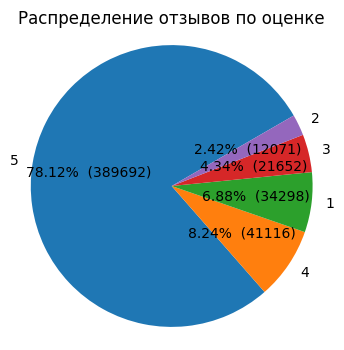

In [5]:
get_plt_value_counts(df['rating'])

In [6]:
def get_balanced_df(df: pd.DataFrame, size) -> pd.DataFrame:
    class_1 = df[df['rating'] == 1]
    class_2 = df[df['rating'] == 2]
    class_3 = df[df['rating'] == 3]
    class_4 = df[df['rating'] == 4]
    class_5 = df[df['rating'] == 5]

    class_1_undersampled = resample(class_1, replace=True, n_samples=size)
    class_2_undersampled = resample(class_2, replace=True, n_samples=size)
    class_3_undersampled = resample(class_3, replace=True, n_samples=size)
    class_4_undersampled = resample(class_4, replace=True, n_samples=size)
    class_5_undersampled = resample(class_5, replace=False, n_samples=size)

    new_df = pd.concat([class_1_undersampled, class_2_undersampled,class_3_undersampled, class_4_undersampled, class_5_undersampled])
    return new_df['text'], new_df['rating']

### Делим выборку на train и test

In [18]:
df['text'] = df['text'].fillna('')
df['rating'] = df['rating'].fillna('')

X = df['text']
y = df['rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_b, y_train_b = get_balanced_df(pd.concat([X_train, y_train], axis=1), 50000)

Делим выборку перед векторизацией, что бы избежать утечки данных при тесте.

### Dataloader

In [19]:
class WordDataset:
    def __init__(self, text, label, token2inx, maxlen=126):
        self.text = text
        self.label = label

        self.token2inx = token2inx
        self.maxlen = maxlen


        self.unk_id = token2inx['<unk>']
        self.pad_id = token2inx['<pad>']

    def __getitem__(self, index):

        processed_text = self.text[index].split()
        tokenized_sentence = [
            self.token2inx.get(word, self.unk_id) for word in processed_text
        ]

        tokenized_sentence = tokenized_sentence[:self.maxlen]

        # Добавление padding, если длина последовательности меньше maxlen
        pad_length = self.maxlen - len(tokenized_sentence)
        tokenized_sentence += [self.pad_id] * pad_length

        train_sample = {"text" : torch.tensor(tokenized_sentence, dtype=torch.long).to(device) ,"label": torch.tensor(self.label[index], dtype=torch.long).to(device)}

        return train_sample

    def __len__(self) -> int:
        return len(self.text)



In [20]:
def yield_tokens(text):
    for line in text:
        yield line.strip().split()

# Disbalanced
vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>", "<pad>"], min_freq = 5)
token2inx = vocab.get_stoi()
inx2token = {inx: token for token, inx in vocab.get_stoi().items()}

# Balanced
vocab_b = build_vocab_from_iterator(yield_tokens(X_train_b), specials=["<unk>", "<pad>"], min_freq = 5)
token2inx_b = vocab_b.get_stoi()
inx2token_b = {inx: token for token, inx in vocab_b.get_stoi().items()}

In [21]:
len(token2inx), len(token2inx_b)

(41185, 54057)

In [22]:
train_dataset = WordDataset(X_train.values, y_train.values - 1, token2inx)
train_dataset_b = WordDataset(X_train_b.values, y_train_b.values - 1, token2inx_b)

test_dataset = WordDataset(X_test.values, y_test.values - 1, token2inx)
test_dataset_b = WordDataset(X_test.values, y_test.values - 1, token2inx_b)





train_dataloader = DataLoader(train_dataset,  batch_size=256, shuffle=True)
train_dataloader_b = DataLoader(train_dataset_b,  batch_size=256, shuffle=True)


test_dataloader = DataLoader(test_dataset, batch_size=1024)
test_dataloader_b =  DataLoader(test_dataset_b, batch_size=1024)

## Обучение моделей <a class="anchor" id="fifth"></a>

### Функции обучения

In [23]:
def get_confusion_matrix(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1, 2, 3, 4, 5],
                yticklabels=[1, 2, 3, 4, 5])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [24]:
def train_dl(model, optimizer, criterion, n_epochs, train_loader, test_loader):

    loss_train = []
    accuracy_train = []
    

    for epoch in range(n_epochs):
        model.train()  # для трейна модели ставим ее в train()
        for batch in tqdm(train_loader, desc=f'Training epoch {epoch + 1}:'):
            texts = batch['text']
            labels = batch['label']
            output = model(texts)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()  # для теста модели ставим ее в eval()

        predicted_labels = []
        true_labels = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Testing epoch {epoch + 1}:'): 
                texts = batch['text']
                labels = batch['label']
                output = model(texts)
                _, predicted = torch.max(output.data, 1)
                
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
    
        print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss}')
        loss_train.append(loss.item())
        print(classification_report(true_labels, predicted_labels))


RNN

In [25]:
class RNN(nn.Module):
    def __init__(self, vocab_size, num_classes = 5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.rnn = nn.RNN(128, 64,  batch_first=True)
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 12)
        self.linear3 = nn.Linear(12, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)


    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        
        output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        
        output = self.dropout(self.linear1(self.relu(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.linear2(self.relu(output)))  # [batch_size, hidden_dim]
        output = self.linear3(self.relu(output))  # [batch_size, hidden_dim]

        return output

In [26]:
vocab_size = len(train_dataloader_b.dataset.token2inx)
n_epochs = 20

rnn_model_b = RNN(vocab_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(rnn_model_b.parameters())

train_dl(rnn_model_b, optimizer, criterion, n_epochs, train_dataloader_b, test_dataloader_b)

Testing epoch 1:: 100%|██████████| 98/98 [00:10<00:00,  9.63it/s]


Epoch [0/20], Loss: 1.0555310249328613
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      6822
           1       0.16      0.23      0.19      2367
           2       0.22      0.35      0.27      4365
           3       0.21      0.58      0.31      8273
           4       0.97      0.75      0.84     77939

    accuracy                           0.70     99766
   macro avg       0.45      0.50      0.45     99766
weighted avg       0.83      0.70      0.74     99766



Testing epoch 2:: 100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Epoch [1/20], Loss: 0.8472462296485901
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      6822
           1       0.18      0.14      0.16      2367
           2       0.24      0.38      0.30      4365
           3       0.23      0.56      0.32      8273
           4       0.96      0.78      0.86     77939

    accuracy                           0.73     99766
   macro avg       0.45      0.52      0.46     99766
weighted avg       0.83      0.73      0.76     99766



Testing epoch 3:: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Epoch [2/20], Loss: 0.6856496334075928
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      6822
           1       0.19      0.23      0.21      2367
           2       0.24      0.40      0.30      4365
           3       0.22      0.58      0.32      8273
           4       0.97      0.76      0.85     77939

    accuracy                           0.71     99766
   macro avg       0.46      0.52      0.47     99766
weighted avg       0.84      0.71      0.76     99766



Testing epoch 4:: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Epoch [3/20], Loss: 0.6632362008094788
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      6822
           1       0.17      0.21      0.19      2367
           2       0.21      0.42      0.28      4365
           3       0.21      0.52      0.30      8273
           4       0.97      0.76      0.85     77939

    accuracy                           0.71     99766
   macro avg       0.44      0.51      0.46     99766
weighted avg       0.83      0.71      0.75     99766



Testing epoch 5:: 100%|██████████| 98/98 [00:10<00:00,  9.54it/s]


Epoch [4/20], Loss: 0.5241421461105347
              precision    recall  f1-score   support

           0       0.60      0.69      0.64      6822
           1       0.18      0.22      0.20      2367
           2       0.20      0.40      0.26      4365
           3       0.19      0.51      0.28      8273
           4       0.97      0.72      0.83     77939

    accuracy                           0.68     99766
   macro avg       0.43      0.51      0.44     99766
weighted avg       0.83      0.68      0.73     99766



Testing epoch 6:: 100%|██████████| 98/98 [00:10<00:00,  9.54it/s]


Epoch [5/20], Loss: 0.5061739683151245
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      6822
           1       0.18      0.21      0.20      2367
           2       0.22      0.41      0.29      4365
           3       0.21      0.56      0.30      8273
           4       0.97      0.75      0.84     77939

    accuracy                           0.70     99766
   macro avg       0.45      0.51      0.45     99766
weighted avg       0.83      0.70      0.75     99766



Testing epoch 7:: 100%|██████████| 98/98 [00:10<00:00,  9.56it/s]


Epoch [6/20], Loss: 0.4118698239326477
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      6822
           1       0.18      0.24      0.21      2367
           2       0.22      0.35      0.27      4365
           3       0.22      0.53      0.31      8273
           4       0.96      0.78      0.86     77939

    accuracy                           0.72     99766
   macro avg       0.45      0.51      0.46     99766
weighted avg       0.83      0.72      0.76     99766



Testing epoch 8:: 100%|██████████| 98/98 [00:10<00:00,  9.61it/s]


Epoch [7/20], Loss: 0.5416045784950256
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      6822
           1       0.17      0.25      0.20      2367
           2       0.21      0.38      0.27      4365
           3       0.23      0.48      0.31      8273
           4       0.96      0.80      0.87     77939

    accuracy                           0.73     99766
   macro avg       0.45      0.51      0.46     99766
weighted avg       0.83      0.73      0.77     99766



Testing epoch 9:: 100%|██████████| 98/98 [00:10<00:00,  9.66it/s]


Epoch [8/20], Loss: 0.3899901211261749
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      6822
           1       0.17      0.23      0.20      2367
           2       0.21      0.36      0.27      4365
           3       0.23      0.51      0.31      8273
           4       0.96      0.79      0.87     77939

    accuracy                           0.72     99766
   macro avg       0.44      0.51      0.46     99766
weighted avg       0.83      0.72      0.76     99766



Testing epoch 10:: 100%|██████████| 98/98 [00:10<00:00,  9.59it/s]


Epoch [9/20], Loss: 0.28319770097732544
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      6822
           1       0.18      0.18      0.18      2367
           2       0.21      0.39      0.28      4365
           3       0.23      0.48      0.31      8273
           4       0.96      0.80      0.87     77939

    accuracy                           0.73     99766
   macro avg       0.44      0.50      0.46     99766
weighted avg       0.82      0.73      0.77     99766



Testing epoch 11:: 100%|██████████| 98/98 [00:10<00:00,  9.59it/s]


Epoch [10/20], Loss: 0.40708276629447937
              precision    recall  f1-score   support

           0       0.65      0.60      0.62      6822
           1       0.17      0.23      0.20      2367
           2       0.21      0.37      0.27      4365
           3       0.22      0.51      0.31      8273
           4       0.96      0.78      0.86     77939

    accuracy                           0.72     99766
   macro avg       0.44      0.50      0.45     99766
weighted avg       0.83      0.72      0.76     99766



Testing epoch 12:: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Epoch [11/20], Loss: 0.4020191729068756
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6822
           1       0.17      0.24      0.20      2367
           2       0.20      0.37      0.26      4365
           3       0.21      0.50      0.29      8273
           4       0.96      0.76      0.85     77939

    accuracy                           0.70     99766
   macro avg       0.43      0.50      0.45     99766
weighted avg       0.82      0.70      0.75     99766



Testing epoch 13:: 100%|██████████| 98/98 [00:10<00:00,  9.60it/s]


Epoch [12/20], Loss: 0.2628602385520935
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6822
           1       0.17      0.19      0.18      2367
           2       0.20      0.36      0.26      4365
           3       0.22      0.50      0.31      8273
           4       0.96      0.78      0.86     77939

    accuracy                           0.72     99766
   macro avg       0.43      0.50      0.45     99766
weighted avg       0.82      0.72      0.76     99766



Testing epoch 14:: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Epoch [13/20], Loss: 0.350771427154541
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6822
           1       0.17      0.26      0.21      2367
           2       0.19      0.38      0.26      4365
           3       0.20      0.51      0.29      8273
           4       0.96      0.75      0.84     77939

    accuracy                           0.69     99766
   macro avg       0.44      0.50      0.44     99766
weighted avg       0.83      0.69      0.74     99766



Testing epoch 15:: 100%|██████████| 98/98 [00:10<00:00,  9.62it/s]


Epoch [14/20], Loss: 0.28729456663131714
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      6822
           1       0.17      0.21      0.18      2367
           2       0.20      0.37      0.26      4365
           3       0.22      0.50      0.30      8273
           4       0.96      0.78      0.86     77939

    accuracy                           0.71     99766
   macro avg       0.44      0.49      0.45     99766
weighted avg       0.82      0.71      0.75     99766



Testing epoch 16:: 100%|██████████| 98/98 [00:10<00:00,  9.60it/s]


Epoch [15/20], Loss: 0.28293871879577637
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6822
           1       0.17      0.20      0.19      2367
           2       0.21      0.36      0.26      4365
           3       0.22      0.49      0.30      8273
           4       0.96      0.79      0.86     77939

    accuracy                           0.72     99766
   macro avg       0.43      0.50      0.45     99766
weighted avg       0.82      0.72      0.76     99766



Testing epoch 17:: 100%|██████████| 98/98 [00:10<00:00,  9.71it/s]


Epoch [16/20], Loss: 0.2670395076274872
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      6822
           1       0.18      0.21      0.19      2367
           2       0.21      0.33      0.26      4365
           3       0.22      0.50      0.31      8273
           4       0.96      0.80      0.87     77939

    accuracy                           0.72     99766
   macro avg       0.44      0.49      0.45     99766
weighted avg       0.82      0.72      0.76     99766



Testing epoch 18:: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Epoch [17/20], Loss: 0.33509862422943115
              precision    recall  f1-score   support

           0       0.62      0.63      0.62      6822
           1       0.17      0.26      0.21      2367
           2       0.20      0.34      0.25      4365
           3       0.22      0.47      0.30      8273
           4       0.96      0.79      0.86     77939

    accuracy                           0.72     99766
   macro avg       0.43      0.50      0.45     99766
weighted avg       0.82      0.72      0.76     99766



Testing epoch 19:: 100%|██████████| 98/98 [00:10<00:00,  9.60it/s]


Epoch [18/20], Loss: 0.23499096930027008
              precision    recall  f1-score   support

           0       0.65      0.60      0.62      6822
           1       0.18      0.22      0.20      2367
           2       0.21      0.35      0.26      4365
           3       0.23      0.49      0.31      8273
           4       0.95      0.81      0.87     77939

    accuracy                           0.73     99766
   macro avg       0.44      0.49      0.45     99766
weighted avg       0.82      0.73      0.77     99766



Testing epoch 20:: 100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


Epoch [19/20], Loss: 0.17414528131484985
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      6822
           1       0.17      0.20      0.18      2367
           2       0.20      0.37      0.26      4365
           3       0.23      0.46      0.30      8273
           4       0.96      0.80      0.87     77939

    accuracy                           0.72     99766
   macro avg       0.43      0.49      0.45     99766
weighted avg       0.82      0.72      0.76     99766



LSTM

In [16]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, num_classes = 5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(128, 64,  batch_first=True)
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 12)
        self.linear3 = nn.Linear(12, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)


    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        
        output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        
        output = self.dropout(self.linear1(self.relu(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.linear2(self.relu(output)))  # [batch_size, hidden_dim]
        output = self.linear3(self.relu(output))  # [batch_size, hidden_dim]

        return output

In [17]:
vocab_size = len(train_dataloader_b.dataset.token2inx)


lstm_model = LSTM(vocab_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(lstm_model.parameters())

train_dl(lstm_model, optimizer, criterion, n_epochs, train_dataloader_b, test_dataloader_b)

Testing epoch 1:: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


Epoch [0/20], Loss: 1.03719162940979
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      6822
           1       0.17      0.29      0.22      2367
           2       0.23      0.30      0.26      4365
           3       0.23      0.54      0.32      8273
           4       0.96      0.78      0.86     77939

    accuracy                           0.72     99766
   macro avg       0.45      0.51      0.46     99766
weighted avg       0.83      0.72      0.76     99766



Testing epoch 2:: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Epoch [1/20], Loss: 1.0254805088043213
              precision    recall  f1-score   support

           0       0.72      0.58      0.64      6822
           1       0.19      0.36      0.25      2367
           2       0.25      0.35      0.29      4365
           3       0.25      0.53      0.34      8273
           4       0.96      0.81      0.88     77939

    accuracy                           0.74     99766
   macro avg       0.47      0.53      0.48     99766
weighted avg       0.84      0.74      0.78     99766



Testing epoch 3:: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s]


Epoch [2/20], Loss: 0.9315187335014343
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      6822
           1       0.18      0.37      0.24      2367
           2       0.23      0.39      0.29      4365
           3       0.23      0.50      0.32      8273
           4       0.97      0.79      0.87     77939

    accuracy                           0.73     99766
   macro avg       0.46      0.53      0.47     99766
weighted avg       0.83      0.73      0.77     99766



Testing epoch 4:: 100%|██████████| 98/98 [00:10<00:00,  9.15it/s]


Epoch [3/20], Loss: 0.709333598613739
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      6822
           1       0.17      0.37      0.23      2367
           2       0.21      0.41      0.28      4365
           3       0.21      0.47      0.29      8273
           4       0.97      0.77      0.86     77939

    accuracy                           0.71     99766
   macro avg       0.44      0.53      0.46     99766
weighted avg       0.83      0.71      0.75     99766



Testing epoch 5:: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Epoch [4/20], Loss: 0.7797152996063232
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      6822
           1       0.17      0.36      0.23      2367
           2       0.21      0.38      0.27      4365
           3       0.22      0.48      0.30      8273
           4       0.97      0.77      0.86     77939

    accuracy                           0.71     99766
   macro avg       0.44      0.52      0.46     99766
weighted avg       0.83      0.71      0.76     99766



Testing epoch 6:: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


Epoch [5/20], Loss: 0.6753903031349182
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      6822
           1       0.16      0.36      0.22      2367
           2       0.21      0.39      0.28      4365
           3       0.21      0.49      0.30      8273
           4       0.97      0.76      0.85     77939

    accuracy                           0.70     99766
   macro avg       0.44      0.51      0.45     99766
weighted avg       0.83      0.70      0.75     99766



Testing epoch 7:: 100%|██████████| 98/98 [00:11<00:00,  8.62it/s]


Epoch [6/20], Loss: 0.6443706154823303
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      6822
           1       0.16      0.36      0.22      2367
           2       0.22      0.35      0.27      4365
           3       0.22      0.53      0.31      8273
           4       0.97      0.76      0.85     77939

    accuracy                           0.70     99766
   macro avg       0.44      0.51      0.45     99766
weighted avg       0.83      0.70      0.75     99766



Testing epoch 8:: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


Epoch [7/20], Loss: 0.6108072996139526
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      6822
           1       0.15      0.35      0.21      2367
           2       0.21      0.36      0.26      4365
           3       0.21      0.49      0.29      8273
           4       0.96      0.76      0.85     77939

    accuracy                           0.70     99766
   macro avg       0.43      0.51      0.44     99766
weighted avg       0.83      0.70      0.74     99766



Testing epoch 9:: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Epoch [8/20], Loss: 0.38070669770240784
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      6822
           1       0.15      0.34      0.21      2367
           2       0.20      0.39      0.26      4365
           3       0.21      0.46      0.28      8273
           4       0.96      0.75      0.84     77939

    accuracy                           0.69     99766
   macro avg       0.42      0.50      0.44     99766
weighted avg       0.82      0.69      0.74     99766



Testing epoch 10:: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Epoch [9/20], Loss: 0.3807608187198639
              precision    recall  f1-score   support

           0       0.60      0.56      0.58      6822
           1       0.15      0.38      0.21      2367
           2       0.21      0.33      0.25      4365
           3       0.22      0.47      0.30      8273
           4       0.96      0.77      0.86     77939

    accuracy                           0.71     99766
   macro avg       0.43      0.50      0.44     99766
weighted avg       0.82      0.71      0.75     99766



Testing epoch 11:: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


Epoch [10/20], Loss: 0.35405126214027405
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      6822
           1       0.14      0.34      0.20      2367
           2       0.18      0.37      0.25      4365
           3       0.21      0.44      0.28      8273
           4       0.96      0.75      0.84     77939

    accuracy                           0.69     99766
   macro avg       0.41      0.50      0.43     99766
weighted avg       0.82      0.69      0.74     99766



Testing epoch 12:: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Epoch [11/20], Loss: 0.28965726494789124
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      6822
           1       0.14      0.38      0.20      2367
           2       0.19      0.36      0.25      4365
           3       0.21      0.44      0.28      8273
           4       0.96      0.75      0.84     77939

    accuracy                           0.69     99766
   macro avg       0.41      0.50      0.43     99766
weighted avg       0.82      0.69      0.74     99766



Testing epoch 13:: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Epoch [12/20], Loss: 0.2565324604511261
              precision    recall  f1-score   support

           0       0.59      0.55      0.57      6822
           1       0.14      0.35      0.20      2367
           2       0.20      0.37      0.26      4365
           3       0.21      0.46      0.28      8273
           4       0.96      0.75      0.84     77939

    accuracy                           0.69     99766
   macro avg       0.42      0.50      0.43     99766
weighted avg       0.82      0.69      0.74     99766



Testing epoch 14:: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


Epoch [13/20], Loss: 0.20935329794883728
              precision    recall  f1-score   support

           0       0.60      0.55      0.57      6822
           1       0.15      0.36      0.21      2367
           2       0.21      0.30      0.25      4365
           3       0.22      0.48      0.30      8273
           4       0.96      0.77      0.86     77939

    accuracy                           0.70     99766
   macro avg       0.42      0.49      0.44     99766
weighted avg       0.82      0.70      0.75     99766



Testing epoch 15:: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


Epoch [14/20], Loss: 0.13513082265853882
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      6822
           1       0.14      0.36      0.20      2367
           2       0.21      0.32      0.25      4365
           3       0.21      0.49      0.29      8273
           4       0.96      0.76      0.85     77939

    accuracy                           0.69     99766
   macro avg       0.42      0.49      0.43     99766
weighted avg       0.82      0.69      0.74     99766



Testing epoch 16:: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


Epoch [15/20], Loss: 0.2404485046863556
              precision    recall  f1-score   support

           0       0.58      0.53      0.55      6822
           1       0.14      0.38      0.21      2367
           2       0.19      0.34      0.25      4365
           3       0.20      0.47      0.28      8273
           4       0.96      0.74      0.84     77939

    accuracy                           0.68     99766
   macro avg       0.42      0.49      0.43     99766
weighted avg       0.82      0.68      0.73     99766



Testing epoch 17:: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s]


Epoch [16/20], Loss: 0.12466546148061752
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      6822
           1       0.14      0.38      0.21      2367
           2       0.19      0.31      0.23      4365
           3       0.20      0.47      0.28      8273
           4       0.96      0.74      0.84     77939

    accuracy                           0.68     99766
   macro avg       0.41      0.49      0.42     99766
weighted avg       0.82      0.68      0.73     99766



Testing epoch 18:: 100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


Epoch [17/20], Loss: 0.19630013406276703
              precision    recall  f1-score   support

           0       0.58      0.54      0.56      6822
           1       0.14      0.39      0.21      2367
           2       0.20      0.29      0.24      4365
           3       0.21      0.46      0.29      8273
           4       0.96      0.76      0.85     77939

    accuracy                           0.69     99766
   macro avg       0.42      0.49      0.43     99766
weighted avg       0.82      0.69      0.74     99766



Testing epoch 19:: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


Epoch [18/20], Loss: 0.1569107472896576
              precision    recall  f1-score   support

           0       0.59      0.51      0.55      6822
           1       0.14      0.35      0.20      2367
           2       0.20      0.35      0.25      4365
           3       0.19      0.49      0.28      8273
           4       0.96      0.73      0.83     77939

    accuracy                           0.67     99766
   macro avg       0.42      0.49      0.42     99766
weighted avg       0.82      0.67      0.72     99766



Testing epoch 20:: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Epoch [19/20], Loss: 0.12239082902669907
              precision    recall  f1-score   support

           0       0.60      0.49      0.54      6822
           1       0.15      0.37      0.21      2367
           2       0.19      0.36      0.25      4365
           3       0.20      0.47      0.28      8273
           4       0.96      0.75      0.84     77939

    accuracy                           0.68     99766
   macro avg       0.42      0.49      0.42     99766
weighted avg       0.82      0.68      0.73     99766



Вывод: могу сказать, что тут еще много работать. Есть переобучение. Думаю нужно больше данных и использовать другие методы обучения, которые требуют больших вычислительных затрат. К сожалению, я затянул со сдачей работы и не имею столько времени. Я бы продолжил работу над этим датасетом в в будущем. Лучшая модель - Логистическая регресия в моей случае. Есть сложность в определении 2,3,4 - думаю из-за этого и переобучение. Также есть идея в в лучшей обработке данных, убрать лишнии признаки как я и хотел, что возможно для другой модели дасть лучший результат.

## Проверка отзывов

In [31]:
pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 43.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
test_dataset[5]['text'].shape

torch.Size([126])

In [46]:
import nltk
from nltk.tokenize import word_tokenize
import pymorphy2
nltk.download('punkt')

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

morph = pymorphy2.MorphAnalyzer()


def analyze_sentiment(text):
    original_text = text
    text = text.lower()
    text = re.sub(r'[^а-яА-Я ]', '', text)
    text = re.sub('\s+[a-zA-Z]\s+', '', text)
    text = word_tokenize(text, language='russian')
    text = ' '.join(text)

    text = [word for word in text.split() if word not in stop_words]

    lemmatized_words = [morph.parse(word)[0].normal_form for word in text]
    lemmatized_text = " ".join(lemmatized_words)
    
    
    processed_text = lemmatized_text.split()
    tokenized_sentence = [
            train_dataloader_b.dataset.token2inx.get(word, train_dataloader_b.dataset.unk_id) for word in processed_text
    ]
    tokenized_sentence = tokenized_sentence[:train_dataloader_b.dataset.maxlen]

    # Добавление padding, если длина последовательности меньше maxlen
    pad_length = train_dataloader_b.dataset.maxlen - len(tokenized_sentence)
    tokenized_sentence += [train_dataloader_b.dataset.pad_id] * pad_length
    tokenized_sentence = torch.tensor(tokenized_sentence, dtype=torch.long).to(device)
    print(tokenized_sentence)
    print(tokenized_sentence.shape)

    lstm_model(tokenized_sentence)


    print(original_text , y_review)

review = analyze_sentiment("Отличное место")

review = analyze_sentiment("Ужасное место")

review = analyze_sentiment("Неплохое место")

review = analyze_sentiment("Плохое место")

review = analyze_sentiment("Плохое место, но кухня хорошая")

review = analyze_sentiment("Плохое место, но кухня хорошая, офицант нахамил, место грязное")

review = analyze_sentiment("Парк красивый, но очень страшно тут когда темно")

review = analyze_sentiment("Море теплое, отель хороший. Много грязи.")

review = analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")

review = analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")